In [ ]:
%pip install tensorflow opencv-python

  Using cached opencv_python-4.12.0.88-cp37-abi3-win_amd64.whl.metadata (19 kB)
Using cached opencv_python-4.12.0.88-cp37-abi3-win_amd64.whl (39.0 MB)
Note: you may need to restart the kernel to use updated packages.


#### *imports

In [ ]:
import os
import numpy as np
import cv2
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv3D, MaxPooling3D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.utils import to_categorical
import zipfile
import tempfile
import shutil
import glob
import datetime
import matplotlib.pyplot as plt



#### **Extract Data and Labels + initialize train and validation sets**

In [ ]:
# Initialize data and labels as lists
data = []
labels = []

# Function to extract frames from a video file
def extract_frames(video_path, label, frame_limit=30):
    cap = cv2.VideoCapture(video_path)
    frames = []
    count = 0
    while cap.isOpened() and count < frame_limit:
        ret, frame = cap.read()
        if not ret:
            break
        frame = cv2.resize(frame, (112, 112))  # Resize to reduce computational load
        frame = frame / 255.0  # Normalize pixel values
        frames.append(frame)
        count += 1
    cap.release()
    if len(frames) == frame_limit:
        data.append(frames)
        labels.append(label)


import zipfile
import tempfile
import shutil

# Path to the ZIP file
zip_path = r"C:\Users\12484\Downloads\fitDataa.zip"

# Extract ZIP to a temporary directory
temp_dir = tempfile.mkdtemp()
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(temp_dir)

# Define paths to video directories inside the extracted folder
correct_videos_path = os.path.join(temp_dir, "fitDataa", "Correct sequence")
incorrect_videos_path = os.path.join(temp_dir, "fitDataa", "Wrong sequence")

# Process correct videos
for video_file in os.listdir(correct_videos_path):
    extract_frames(os.path.join(correct_videos_path, video_file), 'correct')

# Process incorrect videos
for video_file in os.listdir(incorrect_videos_path):
    extract_frames(os.path.join(incorrect_videos_path, video_file), 'incorrect')

# Convert data and labels to NumPy arrays
data = np.array(data, dtype='float32')
labels = np.array(labels)

# Encode labels to numerical values
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)


#### *?**Extract Data and Labels + initialize train and validation sets with upgraded preproccessing**

In [ ]:
# Initialize data and labels as lists
data = []
labels = []

# Function to extract frames from a video file
def extract_frames(video_path, label, frame_limit=30):
    cap = cv2.VideoCapture(video_path)
    frames = []
    count = 0
    while cap.isOpened() and count < frame_limit:
        ret, frame = cap.read()
        if not ret:
            break
        frame = cv2.resize(frame, (112, 112))  # Resize to reduce computational load
        frame = frame / 255.0  # Normalize pixel values
        frames.append(frame)
        count += 1
    cap.release()
    if len(frames) == frame_limit:
        data.append(frames)
        labels.append(label)

# Define path to RepKeys folder
repkeys_path = os.path.join(os.path.expanduser("~"), "Desktop", "Deep Dive AI Summer 2025", "RepKeys")

print(f"Loading data from: {repkeys_path}")

# Check if RepKeys folder exists
if not os.path.exists(repkeys_path):
    print(f"RepKeys folder not found at: {repkeys_path}")
    print("Please make sure you've run the key frame extraction code first.")
else:
    # Get all video files in RepKeys folder
    video_files = [f for f in os.listdir(repkeys_path) if f.lower().endswith(('.mp4', '.avi', '.mov', '.mkv'))]

    if not video_files:
        print("No video files found in RepKeys folder!")
    else:
        print(f"Found {len(video_files)} video files")

        # Process each video file
        correct_count = 0
        incorrect_count = 0

        for video_file in video_files:
            video_path = os.path.join(repkeys_path, video_file)

            # Extract label from filename
            if '_correct_' in video_file.lower():
                label = 'correct'
                correct_count += 1
            elif '_incorrect_' in video_file.lower():
                label = 'incorrect'
                incorrect_count += 1
            else:
                print(f"⚠️ Skipping {video_file} - no clear label found")
                continue

            # Extract frames and add to dataset
            extract_frames(video_path, label)

        print(f"Processed videos:")
        print(f"   Correct form: {correct_count} videos")
        print(f"   Incorrect form: {incorrect_count} videos")
        print(f"   Total samples loaded: {len(data)}")

# Convert data and labels to NumPy arrays
if len(data) > 0:
    data = np.array(data, dtype='float32')
    labels = np.array(labels)

    print(f"Data shape: {data.shape}")
    print(f"Labels shape: {labels.shape}")

    # Encode labels to numerical values
    lb = LabelBinarizer()
    labels = lb.fit_transform(labels)
    labels = to_categorical(labels)

    print(f"Encoded labels shape: {labels.shape}")

    # Split data into training and testing sets
    if len(data) >= 4:  # Need at least 4 samples for train/test split
        X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

        print(f"Training set: {X_train.shape[0]} samples")
        print(f"Testing set: {X_test.shape[0]} samples")
        print(f"Data ready for model training!")
    else:
        print(f"Not enough samples for train/test split. Need at least 4, got {len(data)}")
else:
    print(f"No data loaded. Please check your RepKeys folder and video files.")

Loading data from: C:\Users\12484\Desktop\Deep Dive AI Summer 2025\RepKeys
Found 182 video files
Processed videos:
   Correct form: 92 videos
   Incorrect form: 90 videos
   Total samples loaded: 181
🔢 Data shape: (181, 30, 112, 112, 3)
🏷️ Labels shape: (181,)
📋 Encoded labels shape: (181, 2)
Training set: 144 samples
Testing set: 37 samples
Data ready for model training!


#### ***LOAD LATEST MODEL**

In [ ]:
# Define output_dir if not already defined
output_dir = os.path.join(os.path.expanduser("~"), "Downloads", "Pushup Models")
os.makedirs(output_dir, exist_ok=True)  # Ensure the directory exists

# Find all model files and get the most recent
model_pattern = os.path.join(output_dir, 'pushup_classification*.h5')
model_files = glob.glob(model_pattern)

if model_files:
    # Sort by modification time, get most recent
    latest_model = max(model_files, key=os.path.getmtime)
    model = load_model(latest_model)
    model_name = os.path.basename(latest_model)
    print(f"Loaded most recent model: {model_name}")
else:
    print("No existing model found. Training the initial model first with the code above.")
    model = None

Loaded most recent model: pushup_classification_improved_20250730_150234.h5


#### *?**Initialize a 3D CNN (Convolutional Neural Network)** for analyzing video sequences

C:\Users\12484\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 50s 1s/step - accuracy: 0.6414 - loss: 75.9831 - val_accuracy: 0.5135 - val_loss: 96.9879
Epoch 2/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 45s 1s/step - accuracy: 0.7981 - loss: 72.0274 - val_accuracy: 0.5946 - val_loss: 66.7535
Epoch 3/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 46s 1s/step - accuracy: 0.8836 - loss: 35.7297 - val_accuracy: 0.6486 - val_loss: 23.2993
Epoch 4/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 45s 1s/step - accuracy: 0.8882 - loss: 47.5906 - val_accuracy: 0.7027 - val_loss: 15.0202
Epoch 5/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 45s 1s/step - accuracy: 0.9148 - loss: 16.7881 - val_accuracy: 0.5946 - val_loss: 149.9016
Epoch 6/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 44s 1s/step - accuracy: 0.9149 - loss: 17.1117 - val_accuracy: 0.8108 - val_loss: 65.5556
Epoch 7/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 43s 1s/step - accuracy: 0.8974 - loss: 37.8411 - val_accuracy: 0.8649 - val_loss: 9.0007
Epoch 8/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 44s 1s/step - accuracy: 0.9627 - loss: 2.2975 - val_accuracy: 0.81

Test Accuracy: 86.49%


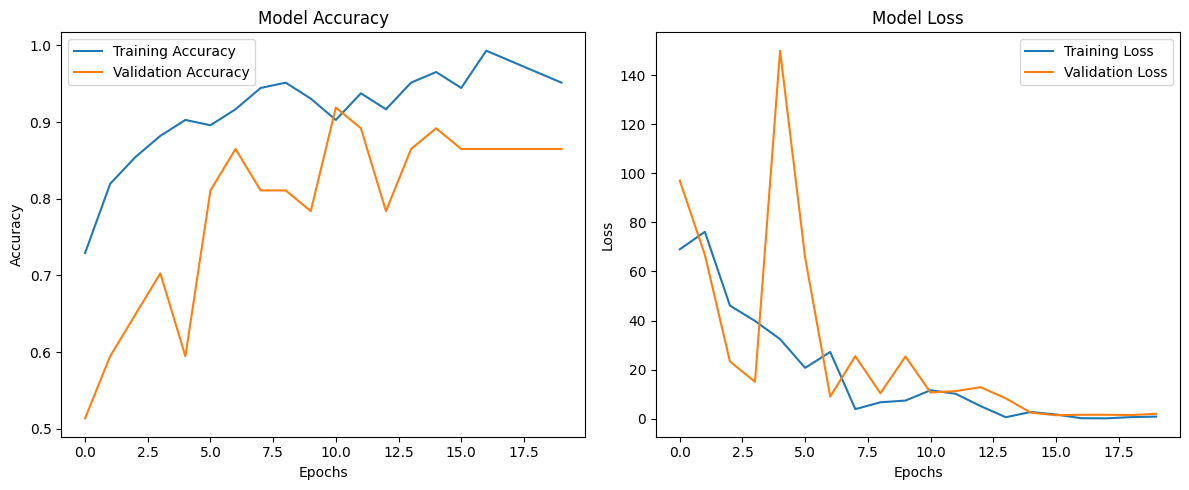

In [ ]:
# Build the model
model = Sequential()
model.add(Conv3D(32, (3, 3, 3), activation='relu', input_shape=(30, 112, 112, 3)))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(Dropout(0.25))

model.add(Conv3D(64, (3, 3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))

# Compile the model
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=20, batch_size=4, validation_data=(X_test, y_test))

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {accuracy * 100:.2f}%')

# Save the model to "Pushup Models" folder in downloads
output_dir = os.path.join(os.path.expanduser("~"), "Downloads", "Pushup Models")

# Create improved model filename with timestamp
timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
improved_model_path = os.path.join(output_dir, f'pushup_classification_improved_{timestamp}.h5')

# Save the improved model to new file (keeps original intact)
model.save(improved_model_path)
print(f"Improved model saved at: {improved_model_path}")

# graph
# Create subplots for accuracy and loss
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Plot accuracy
ax1.plot(history.history['accuracy'], label='Training Accuracy')
ax1.plot(history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_title('Model Accuracy')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Accuracy')
ax1.legend()

# Plot loss
ax2.plot(history.history['loss'], label='Training Loss')
ax2.plot(history.history['val_loss'], label='Validation Loss')
ax2.set_title('Model Loss')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Loss')
ax2.legend()

plt.tight_layout()
plt.show()

##### This code implements a **3D CNN** for **Video Classification**

- 3D CNN: a **Convolutional Neural Network** for analyzing video sequences
- utilizes **Supervised learning** with labeled training data
- Outputs as a **Binary classification** model (2 classes: correct vs incorrect pushup form)

**Key AI Components:**
- uses 3D Convolution Layers to give access to height × width × time to extract spatial and temporal features
- uses Regularization to prevent overfitting and improve training stability
    BatchNormalization()
    Dropout(0.25)
    MaxPooling3D()
-   Flatten()                        # 3D -> 1D vector
    Dense(128, activation='relu')    # Hidden layer, defines 128 patterns from motion features
    Dropout(0.5)                     # Regularization
    Dense(2, activation='softmax')   # Output layer, Converts 128 combined features into probability scores

#### **Model Extensive Breakdown**
(not dependent on having just ran model cell)

In [ ]:
# Only proceed if model was loaded successfully
if model is not None:
    model.summary()
    model_files = os.path.join(os.path.expanduser("~"), "Downloads", "Pushup Models")

    # Check if test data is available for detailed analysis
    try:
        # Detailed Classification Report and Confusion Matrix
        y_pred = model.predict(X_test)
        y_pred_classes = np.argmax(y_pred, axis=1)

        from sklearn.metrics import classification_report, confusion_matrix
        print(f"\nDetailed Classification Report:")
        y_test_classes = np.argmax(y_test, axis=1)
        print(classification_report(y_test_classes, y_pred_classes, target_names=['Incorrect Form', 'Correct Form']))

        # Confusion Matrix:
        print(f"\nConfusion Matrix:")
        cm = confusion_matrix(y_test_classes, y_pred_classes)
        print(f"                 Predicted")
        print(f"                Incorrect  Correct")
        print(f"Actual Incorrect     {cm[0,0]:2d}       {cm[0,1]:2d}")
        print(f"Actual Correct       {cm[1,0]:2d}       {cm[1,1]:2d}")

    except NameError:
        print(f"\nTest data (X_test, y_test) not available in current session.")
        print(f"Run the data preprocessing cell first to perform detailed analysis.")
        print(f"Model loaded successfully and ready for inference!")

# Print all model weights
for i, weight in enumerate(model.weights):
    print(f"Weight {i}: {weight.name}, shape: {weight.shape}")
    print(weight.numpy())
else:
    print(f"\nPlease run the training cells first to create a model.")

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv3d (Conv3D)                 │ (None, 28, 110, 110,   │         2,624 │
│                                 │ 32)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 28, 110, 110,   │           128 │
│ (BatchNormalization)            │ 32)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d (MaxPooling3D)    │ (None, 14, 55, 55, 32) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 14, 55, 55, 32) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_1 (Conv3D)               │ (None, 12, 53, 53, 64) │        55,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 12, 53, 53, 64) │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_1 (MaxPooling3D)  │ (None, 6, 26, 26, 64)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 6, 26, 26, 64)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 259584)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    33,226,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 33,285,508 (126.97 MB)

 Trainable params: 33,285,314 (126.97 MB)

 Non-trainable params: 192 (768.00 B)

 Optimizer params: 2 (12.00 B)


Test data (X_test, y_test) not available in current session.
Run the data preprocessing cell first to perform detailed analysis.
Model loaded successfully and ready for inference!
Weight 0: kernel, shape: (3, 3, 3, 3, 32)
[[[[[-7.7165142e-02 -1.9479308e-02  2.9237187e-02 ... -5.8568936e-02
      6.8114139e-03 -3.4576159e-02]
    [ 3.7747894e-03  4.3986883e-02  3.2619543e-02 ... -2.0173514e-02
      4.3157075e-02  2.0636246e-03]
    [ 8.0139711e-02 -4.6932944e-03  6.2017802e-02 ... -7.1650758e-02
      8.4111519e-02  1.0164177e-02]]

   [[-2.5773976e-02  4.6922948e-02 -4.0926434e-02 ...  5.3367432e-02
     -7.3976137e-02  7.0006013e-02]
    [ 7.7030018e-02 -4.1425582e-02 -4.5700267e-02 ... -2.0396303e-02
      6.3888527e-02  3.2120604e-02]
    [-2.0504886e-02  4.4807550e-02 -4.1825441e-03 ... -3.4905694e-02
     -9.9636195e-03  8.5297279e-02]]

   [[-1.1838123e-03 -1.1382829e-02  7.0860118e-02 ... -3.7609923e-03
     -3.5928607e-02  6.8489588e-03]
    [-4.8157819e-02  1.1152678e-02 -2.

#### *?**Load more epochs on existing saved model**

Loaded most recent model: pushup_classification_improved_20250730_155425.h5
Starting additional training for 5 epochs...
Skipping training: name 'X_train' is not defined
Ensure X_train, y_train, X_test, and y_test are defined before training.


Improved model saved at: C:\Users\12484\Downloads\Pushup Models\pushup_classification_improved_20250730_155444.h5
Latest improved version saved at: C:\Users\12484\Downloads\Pushup Models\pushup_classification_latest_improved.h5


NameError: name 'history' is not defined

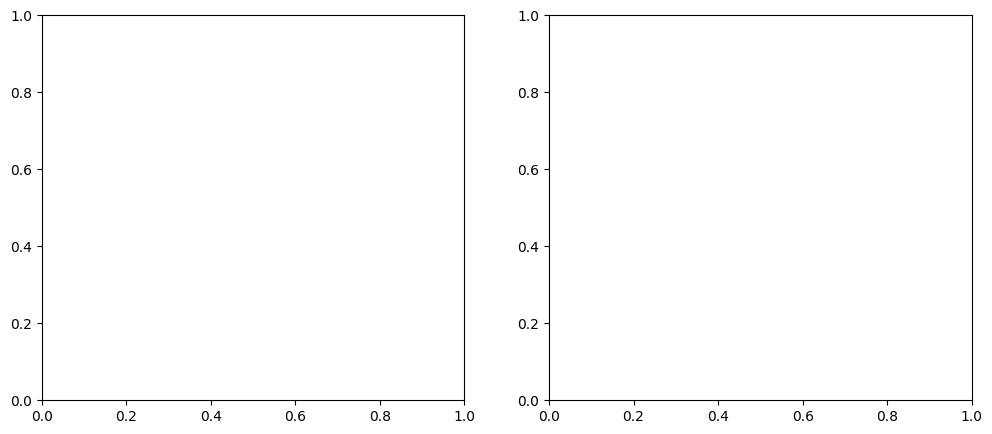

In [ ]:
# to load more epochs on the existing model and save improved version separately in the "Pushup Models" folder in downloads

# Define output_dir if not already defined
output_dir = os.path.join(os.path.expanduser("~"), "Downloads", "Pushup Models")
os.makedirs(output_dir, exist_ok=True)  # Ensure the directory exists

# Find all model files and get the most recent
model_pattern = os.path.join(output_dir, 'pushup_classification*.h5')
model_files = glob.glob(model_pattern)

if model_files:
    # Sort by modification time, get most recent
    latest_model = max(model_files, key=os.path.getmtime)
    model = load_model(latest_model)
    model_name = os.path.basename(latest_model)
    print(f"Loaded most recent model: {model_name}")
else:
    print("No existing model found. Training the initial model first with the code above.")
    model = None

## Continue training
print(f"Starting additional training for 5 epochs...")
try:
    history = model.fit(X_train, y_train, epochs=5, batch_size=4, validation_data=(X_test, y_test))
    print("Training completed successfully!")
except NameError as e:
    print(f"Skipping training: {e}")
    print("Ensure X_train, y_train, X_test, and y_test are defined before training.")

# Create improved model filename with timestamp
timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
improved_model_path = os.path.join(output_dir, f'pushup_classification_improved_{timestamp}.h5')

# Save the improved model to new file (keeps original intact)
model.save(improved_model_path)
print(f"Improved model saved at: {improved_model_path}")


# graph
# Create subplots for accuracy and loss
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Plot accuracy
ax1.plot(history.history['accuracy'], label='Training Accuracy')
ax1.plot(history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_title('Model Accuracy')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Accuracy')
ax1.legend()

# Plot loss
ax2.plot(history.history['loss'], label='Training Loss')
ax2.plot(history.history['val_loss'], label='Validation Loss')
ax2.set_title('Model Loss')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Loss')
ax2.legend()

plt.tight_layout()
plt.show()

#### **LIVE FEED/USER INPUT ATTEMPTS**

In [ ]:

#      THIS IS FOR LIVE FEED/USER INPUT
# ATTEMPT ONE

# Function to extract frames from a new video for prediction
def extract_frames_for_prediction(video_path, frame_limit=30):
    cap = cv2.VideoCapture(video_path)
    frames = []
    count = 0
    while cap.isOpened() and count < frame_limit:
        ret, frame = cap.read()
        if not ret:
            break
        frame = cv2.resize(frame, (112, 112))
        frame = frame / 255.0
        frames.append(frame)
        count += 1
    cap.release()
    if len(frames) < frame_limit:
        for _ in range(frame_limit - len(frames)):
            frames.append(np.zeros((112, 112, 3), dtype='float32'))
    return np.array(frames, dtype='float32')

# Load the most recent trained model
# Define output_dir if not already defined
    output_dir = os.path.join(os.path.expanduser("~"), "Downloads", "Pushup Models")
    os.makedirs(output_dir, exist_ok=True)  # Ensure the directory exists

    # Find all model files and get the most recent
    model_pattern = os.path.join(output_dir, 'pushup_classification*.h5')
    model_files = glob.glob(model_pattern)

    if model_files:
        # Sort by modification time, get most recent
        latest_model = max(model_files, key=os.path.getmtime)
        model = load_model(latest_model)
        model_name = os.path.basename(latest_model)
        print(f"Loaded most recent model: {model_name}")

        classifier = LivePushupClassifier(latest_model) # Initialize classifier with the loaded model

    else:
        print("No existing model found.")
        model = None


# Path to the new video
new_video_path =

# Extract frames from the new video
video_frames = extract_frames_for_prediction(new_video_path)

# Predict the class of the new video
prediction = model.predict(np.expand_dims(video_frames, axis=0))
predicted_class = np.argmax(prediction, axis=1)

# Map the predicted class back to the label
labels = ['correct', 'incorrect']
result = labels[predicted_class[0]]

print(f"The video is classified as: {result}")

SyntaxError: invalid syntax (1324677201.py, line 47)

In [ ]:
# Real-Time Video Preocessing for Live Feed
# ATTEMPT 2

# MUST RUN LOAD MODEL CODE FIRST

# Initialize frame buffer to store 30 frames
frame_buffer = deque(maxlen=30)
frame_count = 0

# Initialize webcam
cap = cv2.VideoCapture(0)  # 0 for default camera
cap.set(cv2.CAP_PROP_FRAME_WIDTH, 640)
cap.set(cv2.CAP_PROP_FRAME_HEIGHT, 480)

print("Press 'q' to quit, 'r' to reset buffer")

while True:
    ret, frame = cap.read()
    if not ret:
        break

    # Preprocess frame (same as training)
    processed_frame = cv2.resize(frame, (112, 112))
    processed_frame = processed_frame / 255.0

    # Add frame to buffer
    frame_buffer.append(processed_frame)
    frame_count += 1

    # Make prediction when buffer is full
    if len(frame_buffer) == 30:
        # Convert buffer to numpy array
        video_sequence = np.array(list(frame_buffer), dtype='float32')
        video_sequence = np.expand_dims(video_sequence, axis=0)  # Add batch dimension

        # Predict
        prediction = model.predict(video_sequence, verbose=0)
        predicted_class = np.argmax(prediction, axis=1)[0]
        confidence = np.max(prediction) * 100

        # Map prediction to label
        labels = ['Incorrect Form', 'Correct Form']
        result = labels[predicted_class]

        # Display result on frame
        color = (0, 255, 0) if predicted_class == 1 else (0, 0, 255)
        cv2.putText(frame, f"{result}: {confidence:.1f}%",
                   (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.7, color, 2)
        cv2.putText(frame, f"Frames: {frame_count}",
                   (10, 60), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1)
    else:
        # Show buffer filling status
        cv2.putText(frame, f"Buffering: {len(frame_buffer)}/30",
                   (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 0), 2)

    # Display the frame
    cv2.imshow('Pushup Form Checker', frame)

    # Handle key presses
    key = cv2.waitKey(1) & 0xFF
    if key == ord('q'):
        break
    elif key == ord('r'):
        frame_buffer.clear()
        frame_count = 0
        print("Buffer reset")

# Release resources
cap.release()
cv2.destroyAllWindows()

Press 'q' to quit, 'r' to reset buffer


##### **Final Live Feed Model** (in progress)

In [ ]:
# Enhanced Version with Sliding Window:

# No prerequisites required

import cv2
import numpy as np
from tensorflow.keras.models import load_model
from collections import deque
import threading
import time
import glob
import datetime

class LivePushupClassifier:
    def __init__(self, model_path, frame_limit=30): # model was trained on 30 frames
        self.model = load_model(model_path)
        self.frame_buffer = deque(maxlen=frame_limit) # sliding window buffer of 30 frames
        self.frame_limit = frame_limit
        self.prediction_result = "Initializing..." # current prediction result
        self.confidence = 0.0
        self.is_predicting = False # thread-safe flag to prevent multiple predictions at once

    def preprocess_frame(self, frame):
        # Converts raw camera frame to AI model input format
        processed = cv2.resize(frame, (112, 112))
        processed = processed / 255.0
        return processed.astype('float32')

    def predict_async(self): # Asynchronous Prediction
        # Run prediction in separate thread
        if len(self.frame_buffer) == self.frame_limit and not self.is_predicting: # 30 frames taken + Prevent multiple predictions
            self.is_predicting = True

            # Prepare 30 frame sequence
            video_sequence = np.array(list(self.frame_buffer), dtype='float32') # preserves data order and ensures correct data type
            video_sequence = np.expand_dims(video_sequence, axis=0)
            # Add batch dimension for model input
            # video_sequence shape: (1, 30, 112, 112, 3) bc TensorFlow/Keras expects 5D input for Conv3D

            # Predict (in background thread)
            prediction = self.model.predict(video_sequence, verbose=0) # Outputs probability array [[0.15, 0.85]] (Incorrect: 15%, Correct: 85%)
            predicted_class = np.argmax(prediction, axis=1)[0]
            self.confidence = np.max(prediction) * 100

            # Update result
            labels = ['Incorrect Form', 'Correct Form']
            self.prediction_result = labels[predicted_class]

            self.is_predicting = False

    def add_frame(self, frame):
        # Add frame to buffer and trigger prediction
        processed_frame = self.preprocess_frame(frame)
        self.frame_buffer.append(processed_frame) # Add processed frame to sliding window buffer

        # Start prediction in background thread when buffer is full(30 frames)
        if len(self.frame_buffer) == self.frame_limit:
            threading.Thread(target=self.predict_async, daemon=True).start()
            # creates a new thread for prediction to avoid blocking the main thread
            # target = the function to run in the new thread
            # daemon=True allows the thread to close when the main program closes

    def get_result(self):
        # Get current prediction result
        return self.prediction_result, self.confidence

# Usage
def run_live_classifier():
    # Define output_dir if not already defined
    output_dir = os.path.join(os.path.expanduser("~"), "Downloads", "Pushup Models")
    os.makedirs(output_dir, exist_ok=True)  # Ensure the directory exists

    # Find all model files and get the most recent
    model_pattern = os.path.join(output_dir, 'pushup_classification*.h5')
    model_files = glob.glob(model_pattern)

    if model_files:
        # Sort by modification time, get most recent
        latest_model = max(model_files, key=os.path.getmtime)
        model = load_model(latest_model)
        model_name = os.path.basename(latest_model)
        print(f"Loaded most recent model: {model_name}")

        classifier = LivePushupClassifier(latest_model) # Initialize classifier with the loaded model

    else:
        print("No existing model found.")
        model = None

    # Initialize webcam
    cap = cv2.VideoCapture(0)
    cap.set(cv2.CAP_PROP_FRAME_WIDTH, 640)
    cap.set(cv2.CAP_PROP_FRAME_HEIGHT, 480)

    print("Live Pushup Form Checker - Press 'q' to quit")

    while True:
        ret, frame = cap.read()
        if not ret:
            break

        # Add frame to classifier
        classifier.add_frame(frame) # add to sliding window buffer

        # Get prediction result
        result, confidence = classifier.get_result() # gets latest prediction result

        # Display result
        if "Correct" in result:
            color = (0, 255, 0)  # Green
        elif "Incorrect" in result:
            color = (0, 0, 255)  # Red
        else:
            color = (255, 255, 0)  # Yellow

        # displays overlay text on frame
        cv2.putText(frame, f"{result}", (10, 30),
                   cv2.FONT_HERSHEY_SIMPLEX, 0.8, color, 2)
        cv2.putText(frame, f"Confidence: {confidence:.1f}%", (10, 60),
                   cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 2)
        cv2.putText(frame, f"Buffer: {len(classifier.frame_buffer)}/30", (10, 90),
                   cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1)

        # Creates Display frame window
        cv2.imshow('Live Pushup Form Checker', frame)

        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    cap.release()
    cv2.destroyAllWindows()

# Run the live classifier
run_live_classifier()

NameError: name 'os' is not defined

In [ ]:
"""

1st implementation:
- simple implementation of video proccessing
- unfinished and basic
- slow


2nd implementation:
- simple linear approach
- proccesses frames one by one
- waits for each prediction to complete before continuing
- blocking prediction: everything stops during prediction - causes choppy display
- Everything in main loop
    while True:
        # capture, process, predict, display all in sequence


3rd implementation:
- uses python classes
- Asynchronous predictions - runs predictions in background threads
- smoother camera feed while running
- Non-blocking prediction with threading: independent prediction and recording proccesses
- Modular class-based approach
    class LivePushupClassifier:
        def preprocess_frame(self)
        def predict_async(self)
        def add_frame(self)

"""